In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import corner
import pocomc as pc
import pymc as pm
import mistsim as ms

In [2]:
NBINS = 1

### Load data

['ant_temp', 'freq', 'lst']


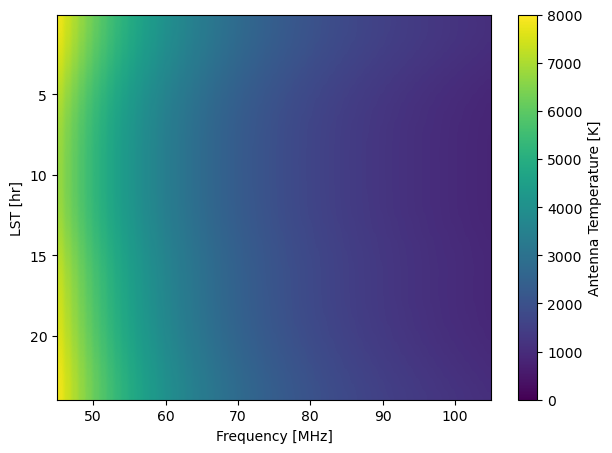

In [3]:
lst, freq, temp = ms.utils.read_hdf5_convolution(
    "../simulations/CSA/CSA_beam_nominal_gsm_no_az_no_tilts_no_mountains.hdf5",
    print_key=True,
)
indx = (freq >= 45) * (freq <= 105)
freq = freq[indx]
temp = temp[:, indx]
nspec, nfreq = temp.shape
fg_mean = temp.mean(axis=0)  # avg spectrum, fg only

plt.figure(figsize=(7,5))
im = plt.imshow(
    temp, aspect="auto", extent=[freq.min(), freq.max(), lst.max(), lst.min()]
)
im.set_clim(0, 8000)
plt.colorbar(label="Antenna Temperature [K]")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

### Global signal

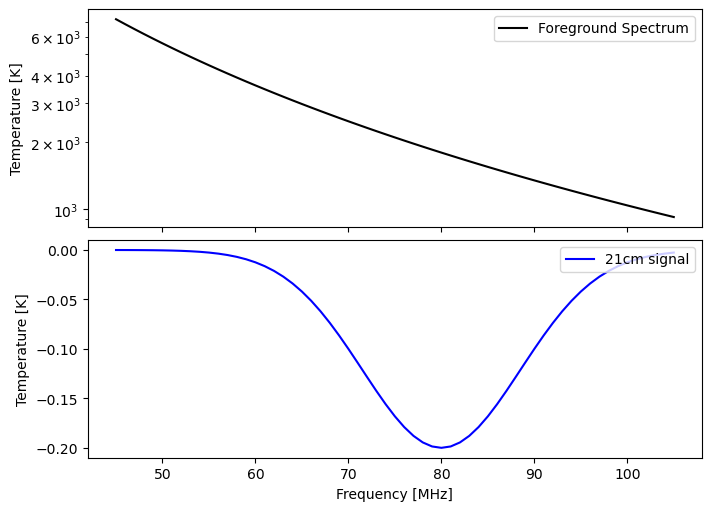

In [4]:
TRUE_PARAMS = {"a": -0.2, "w": 20, "nu21": 80}
TRUE_T21 = ms.utils.gauss(freq, **TRUE_PARAMS)

fig, axs = plt.subplots(figsize=(7,5), nrows=2, sharex=True, constrained_layout=True)
axs[0].semilogy(freq, fg_mean, label="Foreground Spectrum", c="k")
axs[1].plot(freq, TRUE_T21, label="21cm signal", c="blue")
axs[1].set_xlabel("Frequency [MHz]")
for ax in axs:
    ax.legend(loc="upper right")
plt.setp(axs, ylabel="Temperature [K]")
plt.show()

### Foreground model

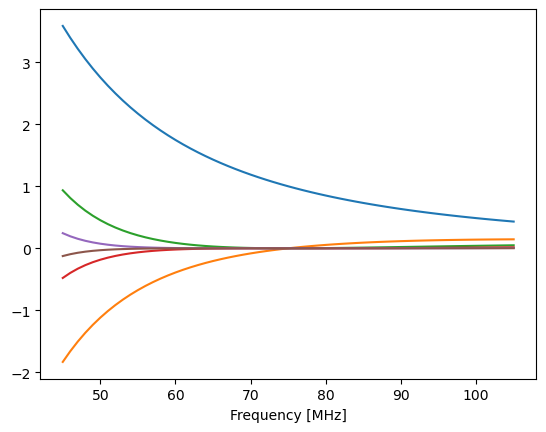

In [5]:
A = ms.utils.design_mat(freq, 6)

plt.figure()
for i in range(A.shape[1]):
    plt.plot(freq, A[:, i])
plt.xlabel("Frequency [MHz]")
plt.show()

### Noise

The noise covariance is taken to be diagonal. We assume systematic uncertainities have been calibrated and are left with radiometer noise. The noise in each frequency channel scales according to the radiometer equation, that is, the standard deviation is proportional to the system temperature and inversly proportional to the root of the integration time.

The first paper took the noise for the 24h avg spectrum to be 3 mK at 75 MHz and we follow that here.

In [6]:
cut = nspec % NBINS
total_temp = temp + TRUE_T21

if cut == 0:
    binned = total_temp.copy()
else:
    binned = total_temp[:-cut]
binned = binned.reshape(nspec//NBINS, NBINS, nfreq).mean(axis=0)


tint_ratio = (nspec//NBINS) / nspec
noise_75 = 3e-3
t75 = total_temp.mean(axis=0)[freq == 75]
noise, sigma_inv = ms.utils.gen_noise(binned, t75, ref_noise=noise_75, tint_ratio=tint_ratio)

In [7]:
NFG = [6]
lst_bins = [ms.lstbin.LSTBin(freq, binned[i]+noise[i], np.diag(sigma_inv[i]), NFG[i]) for i in range(NBINS)]

### Run pocomc

In [9]:
bounds = np.array([[-1., 1.], [1., 60.], [45., 105.]])
results = ms.run_sampler("pocomc", bounds, lst_bins)

Iter: 56it [06:13,  6.67s/it, calls=26500, beta=1, logZ=-31.5, ESS=5.05e+3, acc=0.902, steps=2, logP=-27.7, eff=0.72]    


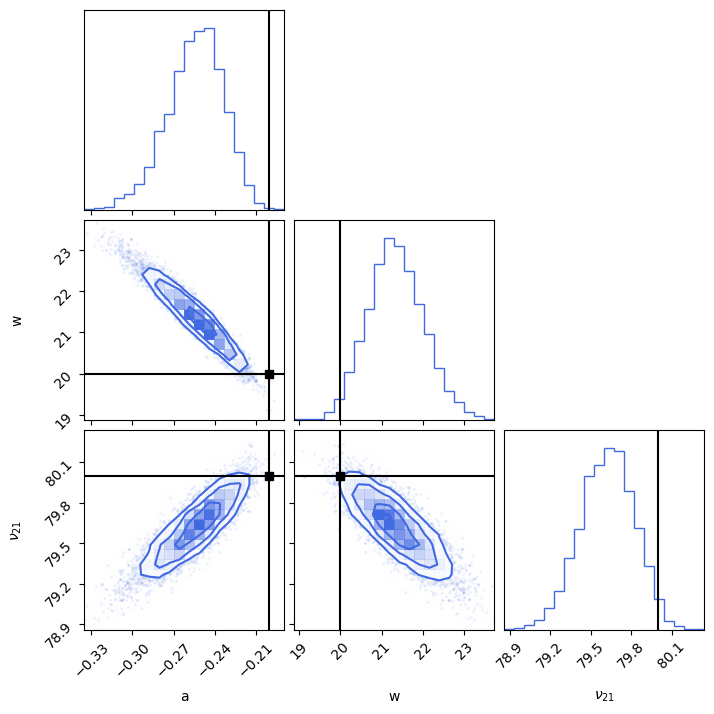

In [10]:
labels = ["a", "w", "$\\nu_{21}$"]
fig = corner.corner(results["samples"], labels=labels, color="royalblue", truths=list(TRUE_PARAMS.values()), truth_color="k")

In [11]:
estimated_params = results["theta_map"]
std_vals = np.std(results['samples'], axis=0)
print('Mean values = ', estimated_params)
print('Standard deviation values = ', std_vals)
print()
print(100 * np.abs(1 - np.array(list(TRUE_PARAMS.values())) /estimated_params))
print(np.abs(estimated_params-np.array(list(TRUE_PARAMS.values())))/std_vals)

Mean values =  [-0.25409625 21.35095813 79.62404822]
Standard deviation values =  [0.02050981 0.67103691 0.20160668]

[21.2896692   6.3273888   0.47215858]
[2.63757905 2.01323969 1.8647784 ]


# Chromaticity correction

In [8]:
path = "CSA/CSA_beam_nominal_gsm_no_az_no_tilts_no_mountains.hdf5"
acp = path.replace(".hdf5", "_achromatic_75MHz.hdf5")
acp

'CSA/CSA_beam_nominal_gsm_no_az_no_tilts_no_mountains_achromatic_75MHz.hdf5'

['ant_temp', 'freq', 'lst']


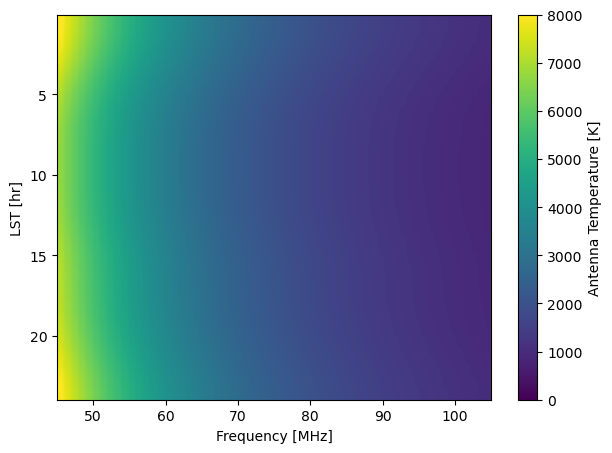

In [9]:
ac_temp = ms.utils.read_hdf5_convolution(f"../simulations/{acp}", print_key=True)[-1]

ac_temp = ac_temp[:, indx]


plt.figure(figsize=(7,5))
im = plt.imshow(
    ac_temp, aspect="auto", extent=[freq.min(), freq.max(), lst.max(), lst.min()]
)
im.set_clim(0, 8000)
plt.colorbar(label="Antenna Temperature [K]")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

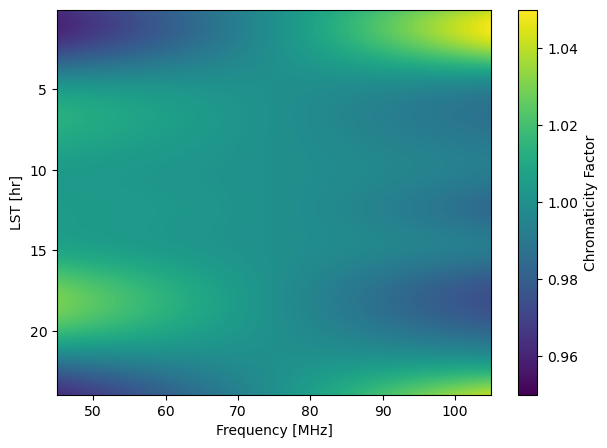

In [10]:
chrom = temp / ac_temp  # chromaticity factor (BF)

plt.figure(figsize=(7,5))
im = plt.imshow(
    chrom, aspect="auto", extent=[freq.min(), freq.max(), lst.max(), lst.min()]
)
im.set_clim(0.95, 1.05)
plt.colorbar(label="Chromaticity Factor")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

In [11]:
ctemp = (temp+TRUE_T21) / chrom  # = ac temp, the waterfall due to achromatic beam

print(np.allclose(ctemp, ac_temp))
if cut == 0:
    binned = ctemp.copy()
else:
    binned = ctemp[:-cut]
    chrom = chrom[:-cut]
binned = binned.reshape(nspec//NBINS, NBINS, nfreq).mean(axis=0)
chrom_mean = chrom.reshape(nspec//NBINS, NBINS, nfreq).mean(axis=0)
print(chrom_mean.shape)

tint_ratio = (nspec//NBINS) / nspec
noise_75 = 3e-3
t75 = ctemp.mean(axis=0)[freq == 75]
noise, sigma_inv = ms.utils.gen_noise(binned, t75, ref_noise=noise_75, tint_ratio=tint_ratio)

False
(1, 61)


In [12]:
print(noise.shape)
print(sigma_inv.shape)
print(chrom_mean.shape)

(1, 61)
(1, 61)
(1, 61)


In [13]:
NFG = [5]
lst_bins = [ms.lstbin.LSTBin(freq, binned[i]+noise[i], np.diag(sigma_inv[i]), NFG[i], chrom=chrom_mean[i]) for i in range(NBINS)]

In [18]:
bounds = np.array([[-1., 1.], [1., 60.], [45., 105.]])
results = ms.run_sampler("pocomc", bounds, lst_bins)

Iter: 15it [00:33,  2.98s/it, calls=3750, beta=0.00206, logZ=-4.03, ESS=1e+3, acc=0.673, steps=1, logP=-807, eff=0.72]       /home/christian/miniconda3/envs/mistsim/lib/python3.11/site-packages/pocomc/scaler.py:269: RuntimeWarning: divide by zero encountered in log
  log_det_J = np.log(np.prod(J, axis=1))
Iter: 59it [06:47,  6.90s/it, calls=24750, beta=1, logZ=-34.6, ESS=4.87e+3, acc=0.915, steps=1, logP=-29.3, eff=0.72]     


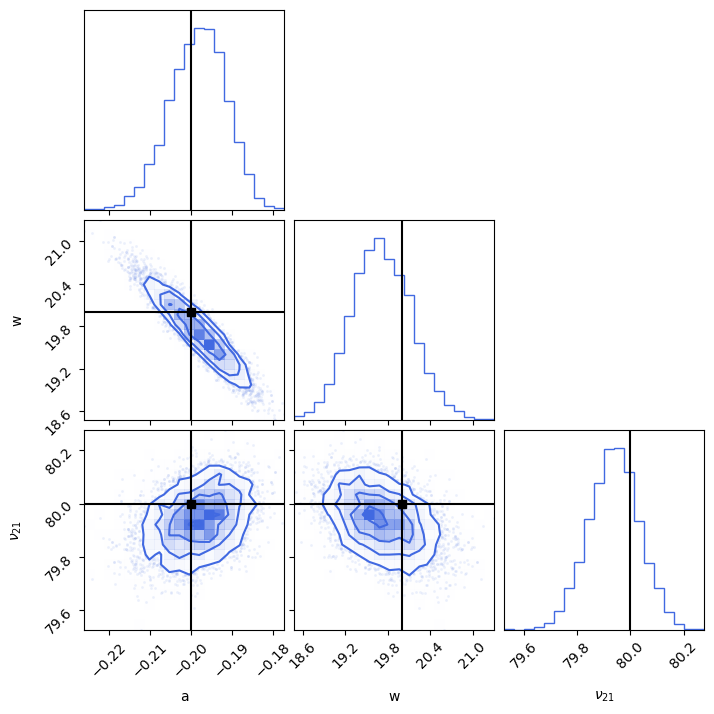

In [19]:
fig = corner.corner(results["samples"], labels=labels, color="royalblue", truths=list(TRUE_PARAMS.values()), truth_color="k")

In [20]:
estimated_params = results["theta_map"]
std_vals = np.std(results['samples'], axis=0)
print('Mean values = ', estimated_params)
print('Standard deviation values = ', std_vals)
print()
print(100 * np.abs(1 - np.array(list(TRUE_PARAMS.values())) /estimated_params))
print(np.abs(estimated_params-np.array(list(TRUE_PARAMS.values())))/std_vals)

Mean values =  [-0.19832657 19.71755042 79.94030328]
Standard deviation values =  [0.00679953 0.41553546 0.0942094 ]

[0.84377741 1.43247804 0.07467663]
[0.2461104  0.67972437 0.63365993]


### Run PyMC

In [14]:
bounds = np.array([[-1., 1.], [1., 60.], [45., 105.]])
idata = ms.run_sampler("pymc", bounds, lst_bins[0])
az.summary(idata, round_to=2)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [15]:
%debug

> /home/christian/miniconda3/envs/mistsim/lib/python3.11/site-packages/pymc/pytensorf.py(112)convert_observed_data()
    110         else:
    111             # already a ndarray, but not masked
--> 112             mask = np.isnan(data)
    113             if np.any(mask):
    114                 ret = np.ma.MaskedArray(data, mask)



ipdb>  ll


     84 def convert_observed_data(data):
     85     """Convert user provided dataset to accepted formats."""
     86 
     87     if hasattr(data, "to_numpy") and hasattr(data, "isnull"):
     88         # typically, but not limited to pandas objects
     89         vals = data.to_numpy()
     90         null_data = data.isnull()
     91         if hasattr(null_data, "to_numpy"):
     92             # pandas Series
     93             mask = null_data.to_numpy()
     94         else:
     95             # pandas Index
     96             mask = null_data
     97         if mask.any():
     98             # there are missing values
     99             ret = np.ma.MaskedArray(vals, mask)
    100         else:
    101             ret = vals
    102     elif isinstance(data, np.ndarray):
    103         if isinstance(data, np.ma.MaskedArray):
    104             if not data.mask.any():
    105                 # empty mask
    106                 ret = data.filled()
    107             els

ipdb>  data


array([Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0,
       Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0,
       Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0,
       Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0,
       Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0,
       Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0,
       Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0], dtype=object)


ipdb>  u


> /home/christian/miniconda3/envs/mistsim/lib/python3.11/site-packages/pymc/distributions/distribution.py(360)__new__()
    358         dims = convert_dims(dims)
    359         if observed is not None:
--> 360             observed = convert_observed_data(observed)
    361 
    362         # Preference is given to size or shape. If not specified, we rely on dims and



ipdb>  ll


    284     def __new__(
    285         cls,
    286         name: str,
    287         *args,
    288         rng=None,
    289         dims: Optional[Dims] = None,
    290         initval=None,
    291         observed=None,
    292         total_size=None,
    293         transform=UNSET,
    294         **kwargs,
    295     ) -> TensorVariable:
    296         """Adds a tensor variable corresponding to a PyMC distribution to the current model.
    297 
    298         Note that all remaining kwargs must be compatible with ``.dist()``
    299 
    300         Parameters
    301         ----------
    302         cls : type
    303             A PyMC distribution.
    304         name : str
    305             Name for the new model variable.
    306         rng : optional
    307             Random number generator to use with the RandomVariable.
    308         dims : tuple, optional
    309             A tuple of dimension names known to the model. When shape is not provided,
  

ipdb>  observed


array([Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0,
       Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0,
       Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0,
       Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0,
       Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0,
       Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0,
       Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0], dtype=object)


ipdb>  u


> /home/christian/miniconda3/envs/mistsim/lib/python3.11/site-packages/mistsim/sampler.py(104)_run_pymc()
    102         t21_model = utils.gauss(lst_bin.freq, a, w, nu21)
    103         dstar = lst_bin.bin_fg_mle(t21_model)[1]
--> 104         Y_obs = pm.MvNormal(
    105             "Y_obs", mu=np.zeros_like(dstar), tau=lst_bin.C_total_inv, observed=dstar
    106         )



ipdb>  dstar


array([Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0,
       Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0,
       Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0,
       Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0,
       Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0,
       Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0,
       Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0], dtype=object)


ipdb>  lst_bin.C_total_inv


array([[ 9.64208833e+03,  9.69421842e+01,  5.12984427e+01, ...,
         2.60783624e+02,  3.86759692e+02,  5.30856807e+02],
       [ 9.84884493e+01,  1.06009517e+04,  3.39956495e+01, ...,
         2.44175456e+02,  3.35829271e+02,  4.40041502e+02],
       [ 5.43591702e+01,  3.51117662e+01,  1.16913045e+04, ...,
         2.28346348e+02,  2.91210703e+02,  3.61996199e+02],
       ...,
       [-1.70318121e+03, -1.21892967e+03, -7.96060477e+02, ...,
         5.26964249e+05, -2.17182849e+03, -2.66283830e+03],
       [-1.89238724e+03, -1.36595615e+03, -9.05668412e+02, ...,
        -1.97620443e+03,  5.52255391e+05, -2.90457023e+03],
       [-2.09008473e+03, -1.52123563e+03, -1.02319853e+03, ...,
        -2.21140636e+03, -2.64082505e+03,  5.78455977e+05]])


ipdb>  t21_model


array([Mul.0, Mul.0, Mul.0, Mul.0, Mul.0, Mul.0, Mul.0, Mul.0, Mul.0,
       Mul.0, Mul.0, Mul.0, Mul.0, Mul.0, Mul.0, Mul.0, Mul.0, Mul.0,
       Mul.0, Mul.0, Mul.0, Mul.0, Mul.0, Mul.0, Mul.0, Mul.0, Mul.0,
       Mul.0, Mul.0, Mul.0, Mul.0, Mul.0, Mul.0, Mul.0, Mul.0, Mul.0,
       Mul.0, Mul.0, Mul.0, Mul.0, Mul.0, Mul.0, Mul.0, Mul.0, Mul.0,
       Mul.0, Mul.0, Mul.0, Mul.0, Mul.0, Mul.0, Mul.0, Mul.0, Mul.0,
       Mul.0, Mul.0, Mul.0, Mul.0, Mul.0, Mul.0, Mul.0], dtype=object)


ipdb>  a


bounds = array([[ -1.,   1.],
       [  1.,  60.],
       [ 45., 105.]])
lst_bin = <mistsim.lstbin.LSTBin object at 0x7f7436d9e990>
kwargs = {}


ipdb>  print(a)


a21


ipdb>  ll


     97 def _run_pymc(bounds, lst_bin, **kwargs):
     98     names = ["a21", "w21", "nu21"]
     99     model = pm.Model()
    100     with model:
    101         a, w, nu21 = [pm.Uniform(n, *b) for n, b in zip(names, bounds)]
    102         t21_model = utils.gauss(lst_bin.freq, a, w, nu21)
    103         dstar = lst_bin.bin_fg_mle(t21_model)[1]
--> 104         Y_obs = pm.MvNormal(
    105             "Y_obs", mu=np.zeros_like(dstar), tau=lst_bin.C_total_inv, observed=dstar
    106         )
    107         idata = pm.sample()
    108     return idata
    109 



ipdb>  print(w)


w21


ipdb>  w21


*** NameError: name 'w21' is not defined


ipdb>  w


    [... skipping 1 hidden frame(s)]

  /tmp/ipykernel_96677/2933053686.py(2)<module>()
      1 bounds = np.array([[-1., 1.], [1., 60.], [45., 105.]])
----> 2 idata = ms.run_sampler("pymc", bounds, lst_bins[0])
      3 az.summary(idata, round_to=2)

  /home/christian/miniconda3/envs/mistsim/lib/python3.11/site-packages/mistsim/sampler.py(88)run_sampler()
     86     sampler = sampler.lower()
     87     if sampler == "pymc":
---> 88         return _run_pymc(prior_bounds, lst_bin, **kwargs)
     89     elif sampler == "pocomc":
     90         prior = uniform_prior(prior_bounds)

> /home/christian/miniconda3/envs/mistsim/lib/python3.11/site-packages/mistsim/sampler.py(104)_run_pymc()
    102         t21_model = utils.gauss(lst_bin.freq, a, w, nu21)
    103         dstar = lst_bin.bin_fg_mle(t21_model)[1]
--> 104         Y_obs = pm.MvNormal(
    105             "Y_obs", mu=np.zeros_like(dstar), tau=lst_bin.C_total_inv, observed=dstar
    106         )

  /home/christian/miniconda3/envs/m

ipdb>  q


In [ ]:
az.plot_trace(idata, combined=True)